Calculation of rewards for the main branch. Currently all our mechs have the same main branch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator
from auto_robot_design.pinokla.calc_criterion import (ActuatedMass, ImfCompute, ManipCompute,
                                                      MovmentSurface, NeutralPoseMass, TranslationErrorMSE, EffectiveInertiaCompute, ManipJacobian)
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import (convert_x_y_to_6d_traj_xz,
                                                    get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory)
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward, ManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import EndPointIMFReward, MassReward, ActuatedMassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point

#### Setup trajectories 

If the trajectory has an unreachable point the cell with reward calculation will fail!

In [2]:
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.5, -0.95], step_height= 0.4, step_width=1,n_points=50))
left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.65, -0.95], step_height= 0.4, step_width=1,n_points=50))
right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.35, -0.95], step_height= 0.4, step_width=1,n_points=50))

central_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0,50))
left_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, -0.2,50))
right_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0.2,50))

#### Characteristics to be calculated

In [3]:
# criteria that either calculated without any reference to points, or calculated through
# the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ), # determinant of the jacobian
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(), # mass term in the dynamic equation with only actuated joints as generalized coordinates
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}

crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

#### set the rewards and weights

In [4]:
rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1), (AccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1), (EndPointIMFReward(imf_key='IMF',
            trajectory_key="traj_6d", error_key="error"), 1), (EndPointZRRReward(manipulability_key='Manip_Jacobian',
             trajectory_key="traj_6d", error_key="error"), 1)]
step_trajectories = [ground_symmetric_step,left_shift_step,right_shift_step]
#step_trajectories = [ground_symmetric_step]

rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1),
           (HeavyLiftingReward(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", mass_key="MASS"), 1), (MassReward(mass_key="MASS"), 1), (ActuatedMassReward(mass_key="Actuated_Mass"),1)]
vertical_trajectories = [central_vertical, left_vertical, right_vertical]
#vertical_trajectories = [central_vertical]

crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

rewards_and_trajectories = [(rewards_step, step_trajectories),(rewards_vertical, vertical_trajectories)]

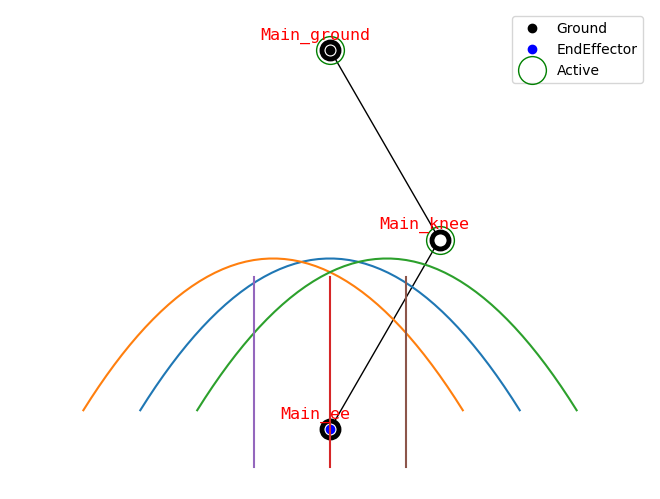

In [5]:
actuator_list = [TMotor_AK10_9(), TMotor_AK60_6(), TMotor_AK70_10(), TMotor_AK80_64(), TMotor_AK80_9()]
generator = TwoLinkGenerator()
generator.build_standard_two_linker()
graph = generator.graph

# open chain is fully actuated
for jp in graph.nodes:
    if not jp.attach_endeffector:
        jp.active = True

rewards_and_trajectories = [(rewards_step, step_trajectories),(rewards_vertical, vertical_trajectories)]


draw_joint_point(graph)

for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])

In [6]:
result_vector = {}
for j in actuator_list:
    # create builder
    thickness = 0.04
    builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
        [thickness*5, thickness*10, thickness*2]), actuator=j, thickness=thickness)
    builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
        [thickness*10, thickness*20, thickness*4]), actuator=j, thickness=thickness)

    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

    total_reward=0
    partial_rewards = []
    for rewards, trajectories in rewards_and_trajectories:
        max_reward = -float('inf')
        max_partial = None
        best_trajectory = None
        for trajectory_id, trajectory in enumerate(trajectories):
            point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
            current_total = 0
            current_partial = []
            for reward, weight in rewards:
                current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=j)[0])
                current_total += weight*current_partial[-1]
            if current_total > max_reward:
                max_reward = current_total
                max_partial = current_partial
                best_trajectory_id = trajectory_id
        total_reward+= max_reward
        partial_rewards.append((best_trajectory_id, max_partial))


    result_vector[j.__class__.__name__] = (total_reward, partial_rewards)

#print(result_vector)
for keys,values in result_vector.items():
    print(keys)
    print(values)

TMotor_AK10_9
(51.53905251666173, [(1, [0, 45.48183014289713, 0.389468789100647, 2.0594885974493264]), (2, [0, 6.648056552802304, -2.912317928126016, -0.12747364])])
TMotor_AK60_6
(11.21975473731111, [(1, [0, 11.171884787964224, 0.39437681436538696, 2.0594885974493264]), (1, [0, 0, -2.3203179281260162, -0.085677534])])
TMotor_AK70_10
(30.701600888871738, [(1, [0, 28.35392511800721, 0.3930078446865082, 2.0594885974493264]), (2, [0, 2.466208887020283, -2.4733179281260163, -0.09771163])])
TMotor_AK80_64
(92.05560232669566, [(0, [0, 72.1716154705052, 0.2737785279750824, 1.7445260298608294]), (2, [0, 21.098618274194788, -2.802317928126016, -0.43061805])])
TMotor_AK80_9
(21.887433835177582, [(1, [0, 20.82071824407221, 0.3932427763938904, 2.0594885974493264]), (2, [0, 1.1478225022221045, -2.437317928126016, -0.09652036])])
